<a href="https://colab.research.google.com/github/SheryllD/diabetic_retinopathy_ml/blob/main/Diabetic_Retinopathy_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New section

# Preprossesing

In [1]:
# Installi Kaggle API
!pip install Kaggle

In [18]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized
License(s): unknown
^C


In [ ]:
# Moving it in the right location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

In [19]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tanlikesmath/diabetic-retinopathy-resized")

print("Path to dataset files:", path)

100%|██████████| 7.25G/7.25G [01:10<00:00, 110MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7


In [ ]:
!kaggle datasets list | head

In [82]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image



In [83]:
# Reviewing the paths
print("Downloaded path:", path)
print("Contents of the folder:")
print(os.listdir(path))

Downloaded path: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7
Contents of the folder:
['trainLabels_cropped.csv', 'resized_train_cropped', 'trainLabels.csv', 'resized_train']


In [84]:
base_path = "/root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7"
print("Contents:", os.listdir(base_path))


Contents: ['trainLabels_cropped.csv', 'resized_train_cropped', 'trainLabels.csv', 'resized_train']


In [87]:
# I am using the cropped images to reduce the noise

images = os.path.join(base_path, "resized_train_cropped", "resized_train_cropped")
labels = os.path.join(base_path, "trainLabels_cropped.csv")

print("Images folder: ", df_images)
print("Labels file:", df_labels)

Images folder:  /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped
Labels file:        Unnamed: 0.1  Unnamed: 0        image  level
0                 0           0      10_left      0
1                 1           1     10_right      0
2                 2           2      13_left      0
3                 3           3     13_right      0
4                 4           4      15_left      1
...             ...         ...          ...    ...
35103         35104       35121  44347_right      0
35104         35105       35122   44348_left      0
35105         35106       35123  44348_right      0
35106         35107       35124   44349_left      0
35107         35108       35125  44349_right      1

[35108 rows x 4 columns]


In [88]:
# Loading the CSV
df_labels = pd.read_csv(labels)
print(df_labels.head())

   Unnamed: 0.1  Unnamed: 0     image  level
0             0           0   10_left      0
1             1           1  10_right      0
2             2           2   13_left      0
3             3           3  13_right      0
4             4           4   15_left      1


In [89]:
# Reviewing the basic info
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35108 entries, 0 to 35107
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  35108 non-null  int64 
 1   Unnamed: 0    35108 non-null  int64 
 2   image         35108 non-null  object
 3   level         35108 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [90]:
df_labels.describe()

,Unnamed: 0.1,Unnamed: 0,level
count,35108.000000,35108.000000,35108.000000
mean,17553.520992,17563.923778,0.525863
std,10134.986560,10139.840349,0.970372
min,0.000000,0.000000,0.000000
25%,8776.750000,8783.750000,0.000000
50%,17553.500000,17565.500000,0.000000
75%,26330.250000,26345.250000,1.000000
max,35108.000000,35125.000000,4.000000


In [91]:
# How many missing?
df_labels.isna().sum()

,0
Unnamed: 0.1,0
Unnamed: 0,0
image,0
level,0


In [92]:
# How many duplicated?
df_labels.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
35103,False
35104,False
35105,False
35106,False


In [93]:
df_num_columns = df_labels.select_dtypes(include="number")
df_num_columns

,Unnamed: 0.1,Unnamed: 0,level
0,0,0,0
1,1,1,0
2,2,2,0
3,3,3,0
4,4,4,1
...,...,...,...
35103,35104,35121,0
35104,35105,35122,0
35105,35106,35123,0
35106,35107,35124,0


In [94]:
df_num_columns.corr()

,Unnamed: 0.1,Unnamed: 0,level
Unnamed: 0.1,1.00000,1.000000,-0.007790
Unnamed: 0,1.00000,1.000000,-0.007789
level,-0.00779,-0.007789,1.000000


In [95]:
# How many classes?
print("Unique labels", df_labels['level'].unique())
print("Class distribution:\n", df_labels["level"].value_counts())

Unique labels [0 1 2 4 3]
Class distribution:
 level
0    25802
2     5288
1     2438
3      872
4      708
Name: count, dtype: int64


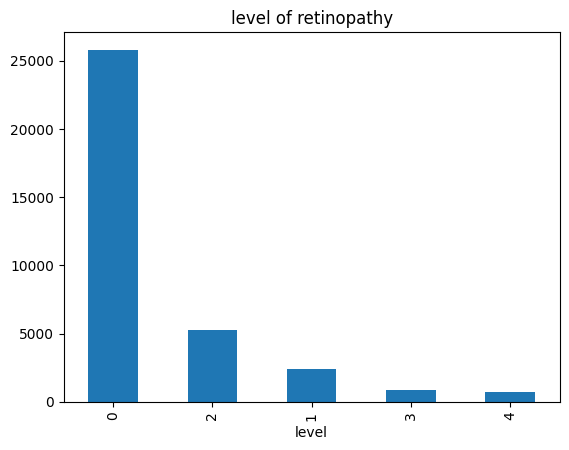

In [96]:
df_labels["level"].value_counts().plot(kind="bar")
plt.title("level of retinopathy")
plt.ylabel("")
plt.show()

0 → no DR
1 → mild
2 → moderate
3 → severe
4 → proliferative

I can see that the data is very imbalanced.

### Reviewing the **images**

In [97]:
# Confirming folder variable
print("Images folder path:", df_images)
print("Example files inside:", os.listdir(df_images)[:5])

Images folder path: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped
Example files inside: ['26978_right.jpeg', '35775_right.jpeg', '2521_left.jpeg', '34287_right.jpeg', '13599_right.jpeg']


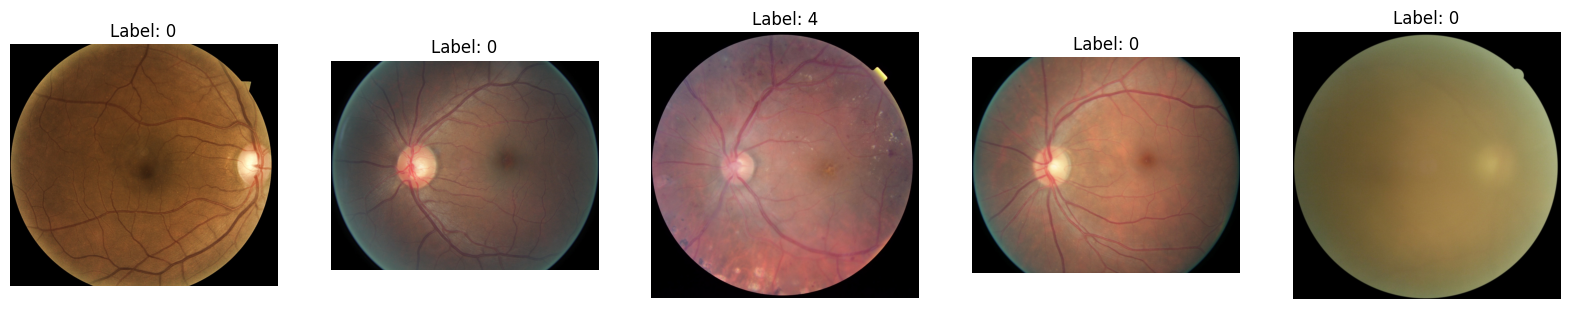

In [107]:
# picking random images
sample = df_labels.sample(5, random_state=42)

# plotting 5 random samples side by side for better overview
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for ax, (_, row) in zip(axes, sample.iterrows()):
    img_path = os.path.join(df_images, row['image'] + '.jpeg')
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Label: {row['level']}")
    ax.axis('off')
plt.show()

# for idx, row in sample.iterrows():
#   img_path = os.path.join(df_images, row['image'] + '.jpeg')
#   img = Image.open(img_path)
#   plt.imshow(img)
#   plt.title(f"Label: {row['level']}")
#   plt.axis("off")
#   plt.show()

Images folder path: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped
Images folder path: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train_cropped/resized_train_cropped
Example files inside: ['26978_right.jpeg', '35775_right.jpeg', '2521_left.jpeg', '34287_right.jpeg', '13599_right.jpeg']
